In [ ]:
!pip install pmdarima

In [ ]:
from pmdarima.arima.utils import ndiffs
from pmdarima.arima import auto_arima

In [ ]:
!pip install statsmodels

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [ ]:
!pip install yfinance
!pip install numpy scipy patsy pandas

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import keras
from sklearn.metrics import mean_absolute_error
import datetime as dt

In [ ]:
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import datetime

In [ ]:
aapl = yf.Ticker("AAPL")
# get stock info
aapl.info
# get historical market data as df
hist1 = aapl.history(period="max")
hist = hist1['2015-01-01': '2020-12-31']
start = "2015-01-01"
end="2020-12-31"
# Save df as CSV
hist.to_csv('AAPL.csv')
# Read back in as dataframe
aapl = pd.read_csv('AAPL.csv')
# Convert Date column to datetime
aapl['Date'] = pd.to_datetime(aapl['Date'])

In [ ]:
# Set target series
series = aapl['Close']
# Create train data set
train_split_date = '2019-12-31'
train_split_index = np.where(aapl.Date == train_split_date)[0][0]
x_train = aapl.loc[aapl['Date'] <= train_split_date]['Close']
# Create test data set
test_split_date = '2020-01-02'
test_split_index = np.where(aapl.Date == test_split_date)[0][0]
x_test = aapl.loc[aapl['Date'] >= test_split_date]['Close']
# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = aapl.loc[(aapl['Date'] < test_split_date) & (aapl['Date'] > train_split_date)]['Close']
#printed index values are: 
#0-5521(train), 5522-6527(valid), 6528-6947(test)

In [ ]:
def data_load_and_train_test_split(company, start, end):
  '''
  Loads data from yfinance and splits into training, validation and testing sets

  Creates variables: stock, train, val and test
  '''
  global stock, close_data, train, test

  # load data and create a new index
  stock = yf.download(company, start, end)
  stock.reset_index(inplace=True)

  # create dataframe of 'Date' and 'Close'
  close_data = stock[['Date', 'Close']]

  # create splits 
  train = close_data[close_data['Date']< datetime.datetime(2020,1,1)]
  test = close_data[close_data['Date']> datetime.datetime(2020,1,1)]

  # remove 'Date' column so we are left with the 'Close' data
  close_data = close_data.filter(['Close'])
  train = train.filter(['Close'])
  test = test.filter(['Close'])

  return print('Orignal data shape:', stock.shape, '\n',
               'Close Dataframe shape:', close_data.shape, '\n',
               'Training set shape:', train.shape, '\n',
               'Testing set shape:', test.shape)

In [ ]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):
  #Determing rolling statistics
  rolmean = timeseries.rolling(window).mean()
  rolstd = timeseries.rolling(window).std()
  #Plot rolling statistics:
  fig = plt.figure(figsize=(12, 8))
  orig = plt.plot(timeseries, color='blue',label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show()
  #Perform Dickey-Fuller test:
  print('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
  if pvalue < cutoff:
    print('p-value = %.4f. The series is likely stationary.' % pvalue)
  else:
    print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    print(dfoutput)

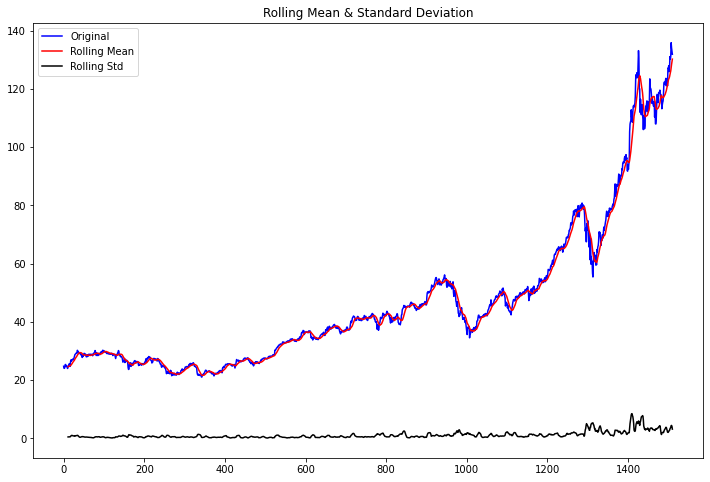

Results of Dickey-Fuller Test:
p-value = 0.9986. The series is likely non-stationary.
Test Statistic                    1.933125
p-value                           0.998579
#Lags Used                       18.000000
Number of Observations Used    1492.000000
Critical Value (1%)              -3.434740
Critical Value (5%)              -2.863479
Critical Value (10%)             -2.567802
dtype: float64


In [ ]:
test_stationarity(series)

In [ ]:
# Get the difference of each Adj Close point
aapl_close_diff_1 = series.diff()
# Drop the first row as it will have a null value in this column
aapl_close_diff_1.dropna(inplace=True)

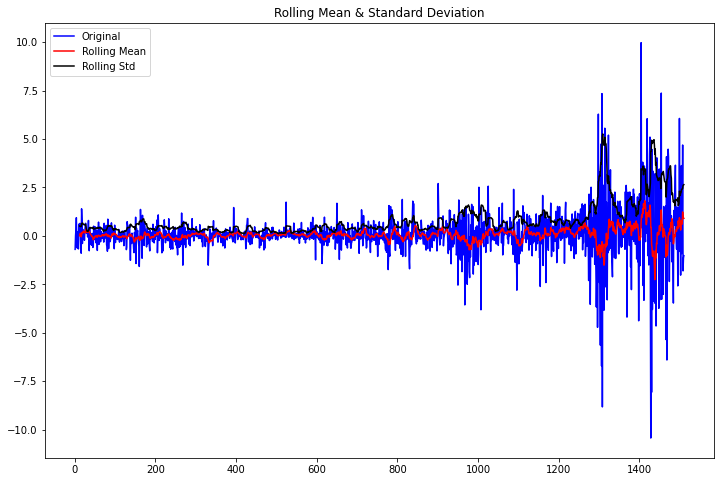

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.


In [ ]:
test_stationarity(aapl_close_diff_1)

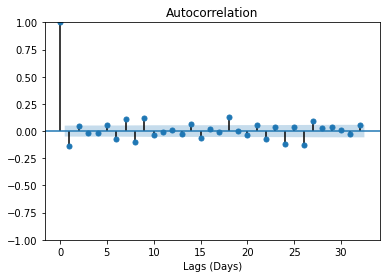

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


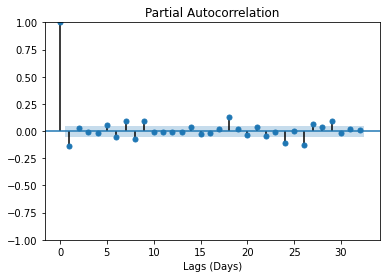

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(aapl_close_diff_1)
plt.xlabel('Lags (Days)')
plt.show()
# Break these into two separate cells
plot_pacf(aapl_close_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

In [ ]:
def num_diff(stock):
  '''
  estimate the number of differencing.
  '''
  kpss_diffs = ndiffs(stock, test='kpss')
  adf_diffs = ndiffs(stock, test="adf")
  return max(adf_diffs, kpss_diffs)

In [ ]:
#example
# n_diffs = num_diff(close_data)
n_diffs = num_diff(x_train)

# ARIMA

In [ ]:
#example
company = 'MSFT'
start = "2015-01-01"
end="2020-12-31"
data_load_and_train_test_split(company,start,end)

[*********************100%***********************]  1 of 1 completed
Orignal data shape: (1510, 7) 
 Close Dataframe shape: (1510, 1) 
 Training set shape: (1258, 1) 
 Testing set shape: (252, 1)


## Number of Differencing

In [ ]:
def num_diff(stock):
  '''
  estimate the number of differencing.
  '''
  kpss_diffs = ndiffs(stock, test='kpss')
  adf_diffs = ndiffs(stock, test="adf")
  return max(adf_diffs, kpss_diffs)

In [ ]:
#example
# n_diffs = num_diff(close_data)
n_diffs = num_diff(train)

## Check if Stationary

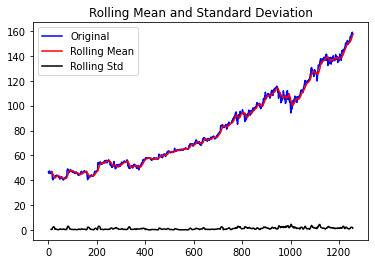

Results of dickey fuller test
Test Statistics                   2.130161
p-value                           0.998820
No. of lags used                  8.000000
Number of observations used    1249.000000
critical value (1%)              -3.435596
critical value (5%)              -2.863857
critical value (10%)             -2.568004
dtype: float64


In [ ]:
def test_stationarity(timeseries):
  '''
  Performs test statistics. If test statistics is bigger 
  than critical value and p-value is bigger than 0.05
  then this timeseries is not stationary
  '''
 #Determing rolling statistics
  rolmean = timeseries.rolling(12).mean()
  rolstd = timeseries.rolling(12).std()

  plt.plot(timeseries, color='blue',label='Original')
  plt.plot(rolmean, color='red', label='Rolling Mean')
  plt.plot(rolstd, color='black', label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean and Standard Deviation')
  plt.show(block=False)
  

  print('Results of dickey fuller test')
  adft = adfuller(timeseries,autolag='AIC')
  output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
  for key,values in adft[4].items():
    output['critical value (%s)'%key] = values
  print(output)
 
test_stationarity(train)

In [ ]:
# Define train_log for seasonality removal

train_log = train.apply(lambda x : np.log(x))

train_log.head()

,Close
0,3.845028
1,3.835790
2,3.821004
3,3.833629
4,3.862623


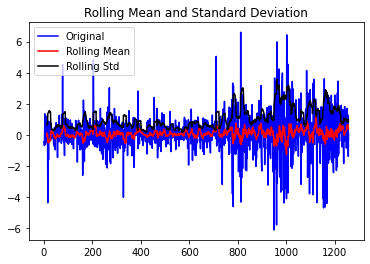

Results of dickey fuller test
Test Statistics               -1.502268e+01
p-value                        1.016923e-27
No. of lags used               7.000000e+00
Number of observations used    1.249000e+03
critical value (1%)           -3.435596e+00
critical value (5%)           -2.863857e+00
critical value (10%)          -2.568004e+00
dtype: float64


In [ ]:
# Remove seasonality
train_log_diff = train - train.shift(n_diffs) 
test_stationarity(train_log_diff.dropna())

## Auto Arima

In Auto ARIMA, the model itself will generate the optimal p, d, and q values which would be suitable for the data set to provide better forecasting

https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd

In [ ]:
def arima_auto(stock):
  
  global arima_model
  arima_model = auto_arima(
      stock,
      start_p=0,
      start_q=0,
      test="adf",
      max_p=6,
      max_q=6,
      m=1,  # frequency of series
      d=n_diffs, 
      seasonal=False,  # no seasonality
      trace=True,
      stepwise=True,
      njob=-1,
  )
  print(arima_model.summary())
  return arima_model

In [ ]:
#example
arima_model = arima_auto(train_log_diff.dropna())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5060.539, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4691.157, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5058.539, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4435.694, Time=0.22 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4365.022, Time=0.26 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4332.469, Time=0.39 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=4286.883, Time=0.49 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=4227.973, Time=0.69 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.83 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.93 sec
 ARIMA(6,1,0)(0,0,0)[0]             : AIC=4225.973, Time=0.28 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=4284.883, Time=0.22 sec
 ARIMA(6,1,1)(0,0,0)[0]             : AIC=inf, Time=1.41 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=1

## Arima Model

In [ ]:
def run_arima(company, start, end):
  # Make first prediction
  data_load_and_train_test_split(company, start, end)
  history = [x for x in train.Close]
  y = test.Close  
  predictions = list()
  model = ARIMA(train, order=(0, 1, 0))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0][0]
  predictions.append(yhat)
  history.append(y[0])

  # Rolling forecasts
  for i in range(1, len(y)):
    # Predict
    model = ARIMA(train, order=(0, 1, 0))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0][0]
    # Invert transformed prediction
    predictions.append(yhat)
    # Observation
    obs = y[i]
    history.append(obs)

  # Report performance
  mse = mean_squared_error(y, predictions)
  print('MSE: ' + str(mse))
  mae = mean_absolute_error(y, predictions)
  print('MAE: ' + str(mae))
  rmse = math.sqrt(mean_squared_error(y, predictions))
  print('RMSE: ' + str(rmse))
  return mse, mae, rmse, history, predictions

In [ ]:
def plot_arima(company, start, end):  
  mse, mae, rmse, history, predictions = run_arima(company, start, end)
  # Plotting ARIMA result
  fig = go.Figure()

  fig.add_trace(go.Scatter(x=train[-250:], y=train[250:], mode='lines', name='Price'))
  fig.add_trace(go.Scatter(x=test, y=test, mode='lines', name='Test price'))
  fig.add_trace(go.Scatter(x=test, y=predictions, mode='lines', name=f'Predicted price of {company}'))

  fig.update_layout(autosize=True, width=1450, height=825,
      title_font=dict(size=25, family='Courier', color='crimson'),
      title=f"ARIMA prediction - Close Price - {company}",
  )

  fig.show()
  return [mse, mae, rmse]

In [ ]:
def get_arima_results(companies, start, end):
  results = []
  titles = ['Stock', 'MSE', 'MAE']
  for company in companies:
    row = plot_arima(company, start, end)
    

In [ ]:
# Create list of x train valuess
history = [x for x in x_train]
# establish list for predictions
model_predictions = []
# Count number of test data points
N_test_observations = len(x_test)
# loop through every data point
for time_point in list(x_test.index):
    model = ARIMA(history, order=(arima_model.order))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)

In [ ]:
#RMSE_error = np.sqrt(mean_squared_error(x_test, model_predictions))
#print('Test Score: %.2f RMSE' % RMSE_error)
mse=mean_squared_error(x_test, model_predictions)
mae=mean_absolute_error(x_test, model_predictions)
mape=mean_absolute_percentage_error(x_test, model_predictions)
print('MSE:  ', mse, '\nMAE:  ', mae,'\nMAPE: ', mape)

MSE:   6.867265772538043 
MAE:   1.8820344802473983 
MAPE:  0.020722404809663447


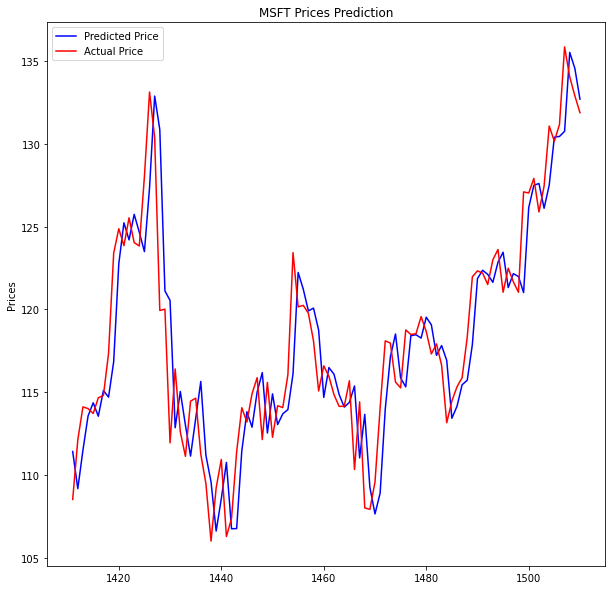

<Figure size 720x432 with 0 Axes>

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(x_test.index[-100:], model_predictions[-100:], color='blue',label='Predicted Price')
plt.plot(x_test.index[-100:], x_test[-100:], color='red', label='Actual Price')
plt.title(company + ' Prices Prediction')
plt.ylabel('Prices')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

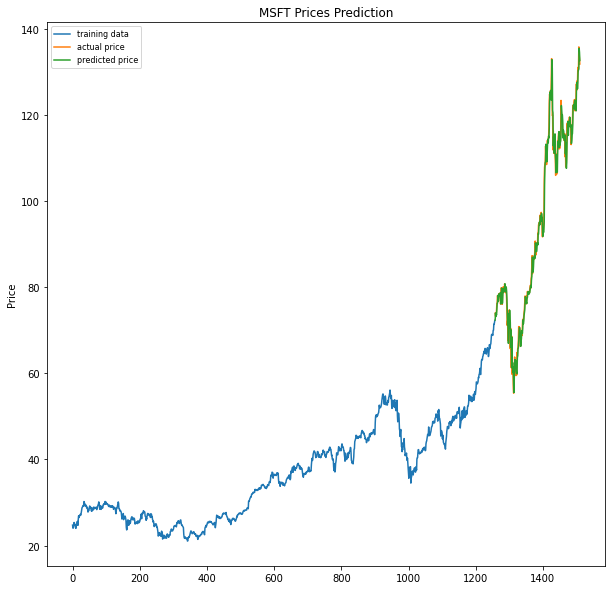

In [ ]:
plt.plot(x_train, label='training data')
plt.plot(x_test, label='actual price')
plt.plot(x_test.index[-len(x_test):],model_predictions[-len(x_test):], label='predicted price')
plt.ylabel('Price')
plt.title(company + ' Prices Prediction')
plt.legend(loc='upper left', fontsize=8)
plt.show()

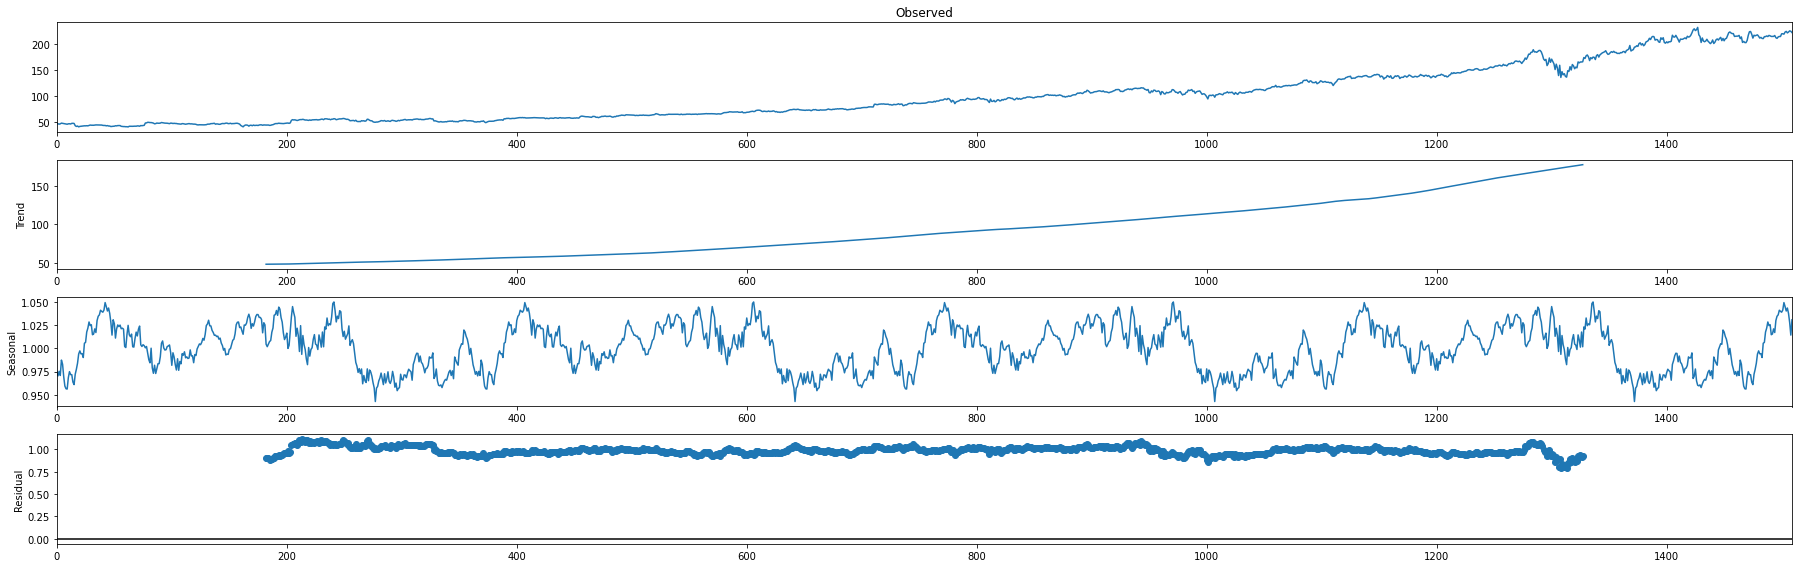

In [ ]:
rcParams['figure.figsize'] = 25, 8

valuessarima =close_data.values
train = train
test = test

result = seasonal_decompose(valuessarima, model='multiplicative', period=365)
fig = result.plot()
plt.show()


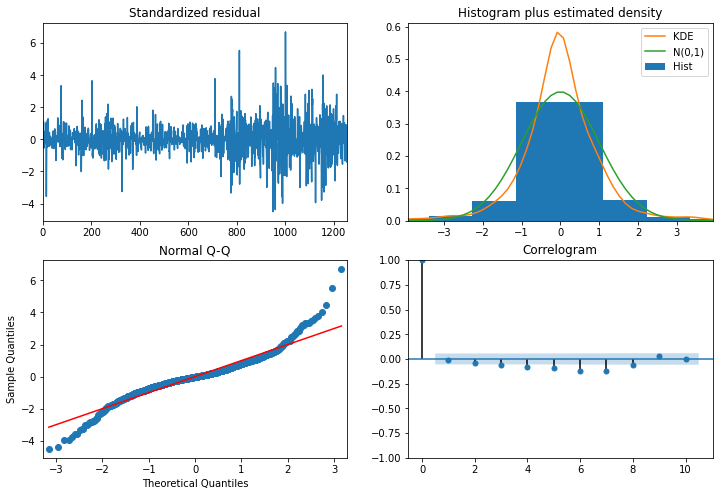

In [ ]:
arima_model.plot_diagnostics(figsize=(12,8))
plt.show()

In [ ]:
############

In [ ]:
start = "2015-01-01"
end="2020-12-31"
companies = ['AAPL', 'MSFT', '2222.SR', 'GOOG', 'AMZN', 'FB', 'TSLA', 'BRK-A', 'TCEHY', 'TSM']

for company in companies:
  #get data
  aapl = yf.Ticker(company)
  # get historical market data as df
  hist1 = aapl.history(period="max")
  hist = hist1['2015-01-01': '2020-12-31']
  start = "2015-01-01"
  end="2020-12-31"
  # Save df as CSV
  hist.to_csv('AAPL.csv')
  # Read back in as dataframe
  aapl = pd.read_csv('AAPL.csv')
  # Convert Date column to datetime
  aapl['Date'] = pd.to_datetime(aapl['Date'])

  # Set target series
  series = aapl['Close']
  # Create train data set
  train_split_date = '2019-12-31'
  train_split_index = np.where(aapl.Date == train_split_date)[0][0]
  x_train = aapl.loc[aapl['Date'] <= train_split_date]['Close']
  # Create test data set
  test_split_date = '2020-01-02'
  test_split_index = np.where(aapl.Date == test_split_date)[0][0]
  x_test = aapl.loc[aapl['Date'] >= test_split_date]['Close']
  # Create valid data set
  valid_split_index = (train_split_index.max(),test_split_index.min())
  x_valid = aapl.loc[(aapl['Date'] < test_split_date) & (aapl['Date'] > train_split_date)]['Close']

  def data_load_and_train_test_split(company, start, end):
    '''
    Loads data from yfinance and splits into training, validation and testing sets

    Creates variables: stock, train, val and test
    '''
    global stock, close_data, train, test

    # load data and create a new index
    stock = yf.download(company, start, end)
    stock.reset_index(inplace=True)

    # create dataframe of 'Date' and 'Close'
    close_data = stock[['Date', 'Close']]

    # create splits 
    train = close_data[close_data['Date']< datetime.datetime(2020,1,1)]
    test = close_data[close_data['Date']> datetime.datetime(2020,1,1)]

    # remove 'Date' column so we are left with the 'Close' data
    close_data = close_data.filter(['Close'])
    train = train.filter(['Close'])
    test = test.filter(['Close'])

    return print('Orignal data shape:', stock.shape, '\n',
                'Close Dataframe shape:', close_data.shape, '\n',
                'Training set shape:', train.shape, '\n',
                'Testing set shape:', test.shape)
    
  def test_stationarity(timeseries, window = 12, cutoff = 0.01):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value
      pvalue = dftest[1]
    if pvalue < cutoff:
      print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
      print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
      print(dfoutput)

  def num_diff(stock):
    '''
    estimate the number of differencing.
    '''
    kpss_diffs = ndiffs(stock, test='kpss')
    adf_diffs = ndiffs(stock, test="adf")
    return max(adf_diffs, kpss_diffs)

  #example
  # n_diffs = num_diff(close_data)
  n_diffs = num_diff(x_train)

  start = "2015-01-01"
  end="2020-12-31"
  data_load_and_train_test_split(company,start,end)

  def test_stationarity(timeseries):
    '''
    Performs test statistics. If test statistics is bigger 
    than critical value and p-value is bigger than 0.05
    then this timeseries is not stationary
    '''
  #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    

    print('Results of dickey fuller test')
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
      output['critical value (%s)'%key] = values
    print(output)
  
  test_stationarity(train)

  # Define train_log for seasonality removal

  train_log = train.apply(lambda x : np.log(x))

  # Remove seasonality
  train_log_diff = train - train.shift(n_diffs) 
  test_stationarity(train_log_diff.dropna())

  def run_arima(company, start, end):
    # Make first prediction
    data_load_and_train_test_split(company, start, end)
    history = [x for x in train.Close]
    y = test.Close  
    predictions = list()
    model = ARIMA(train, order=(0, 1, 0))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0][0]
    predictions.append(yhat)
    history.append(y[0])

    # Rolling forecasts
    for i in range(1, len(y)):
      # Predict
      model = ARIMA(train, order=(0, 1, 0))
      model_fit = model.fit(disp=0)
      yhat = model_fit.forecast()[0][0]
      # Invert transformed prediction
      predictions.append(yhat)
      # Observation
      obs = y[i]
      history.append(obs)

    # Report performance
    mse = mean_squared_error(y, predictions)
    print('MSE: ' + str(mse))
    mae = mean_absolute_error(y, predictions)
    print('MAE: ' + str(mae))
    rmse = math.sqrt(mean_squared_error(y, predictions))
    print('RMSE: ' + str(rmse))
    return mse, mae, rmse, history, predictions
  def plot_arima(company, start, end):  
    mse, mae, rmse, history, predictions = run_arima(company, start, end)
    # Plotting ARIMA result
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=train[-250:], y=train[250:], mode='lines', name='Price'))
    fig.add_trace(go.Scatter(x=test, y=test, mode='lines', name='Test price'))
    fig.add_trace(go.Scatter(x=test, y=predictions, mode='lines', name=f'Predicted price of {company}'))

    fig.update_layout(autosize=True, width=1450, height=825,
        title_font=dict(size=25, family='Courier', color='crimson'),
        title=f"ARIMA prediction - Close Price - {company}",
    )

    fig.show()
    return [mse, mae, rmse]

  def get_arima_results(companies, start, end):
    results = []
    titles = ['Stock', 'MSE', 'MAE']
    for company in companies:
      row = plot_arima(company, start, end)
        
  # Create list of x train valuess
  history = [x for x in x_train]
  # establish list for predictions
  model_predictions = []
  # Count number of test data points
  N_test_observations = len(x_test)
  # loop through every data point
  for time_point in list(x_test.index):
      model = ARIMA(history, order=(arima_model.order))
      model_fit = model.fit()
      output = model_fit.forecast()
      yhat = output[0]
      model_predictions.append(yhat)
      true_test_value = x_test[time_point]
      history.append(true_test_value)

  #RMSE_error = np.sqrt(mean_squared_error(x_test, model_predictions))
  #print('Test Score: %.2f RMSE' % RMSE_error)
  mse=mean_squared_error(x_test, model_predictions)
  mae=mean_absolute_error(x_test, model_predictions)
  mape=mean_absolute_percentage_error(x_test, model_predictions)
  print('MSE:  ', mse, '\nMAE:  ', mae,'\nMAPE: ', mape)
  print(arima_model.order)
  plt.rcParams['figure.figsize'] = [10, 10]
  plt.plot(x_test.index[-100:], model_predictions[-100:], color='blue',label='Predicted Price')
  plt.plot(x_test.index[-100:], x_test[-100:], color='red', label='Actual Price')
  plt.title(company + ' Prices Prediction')
  plt.ylabel('Prices')
  plt.legend()
  plt.figure(figsize=(10,6))
  plt.show()

  plt.plot(x_train, label='training data')
  plt.plot(x_test, label='actual price')
  plt.plot(x_test.index[-len(x_test):],model_predictions[-len(x_test):], label='predicted price')
  plt.ylabel('Price')
  plt.title(company + ' Prices Prediction')
  plt.legend(loc='upper left', fontsize=8)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.